In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Create data:

In [ ]:
# create data

N = 30
x = torch.randn(N,1)
y = x + torch.randn(N,1)/2

# and plot
plt.plot(x,y,'s')
plt.show()

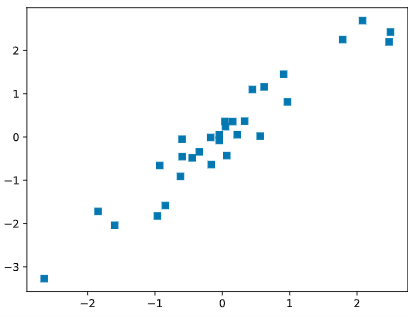

### Build the model:

__nn.Sequential__: a container module allowing to stack layers of a neural network in a sequential manner.

__nn.Linear(in_features, out_features)__: a linear (fully connected) layer 

__nn.ReLU()__: Adding a Rectified Linear Unit (ReLU) activation function: f(x) = max(0, x), which introduces non-linearity to the model.
The ReLU is commonly used because it helps to mitigate the vanishing gradient problem and allows models to learn faster.

In [ ]:
ANNreg = nn.Sequential(
    nn.Linear(1, 1),  # input layer
    nn.ReLU(),        # activation function
    nn.Linear(1, 1)   # output layer
)

ANNreg

Sequential(<br>
  (0): Linear(in_features=1, out_features=1, bias=True)<br>
  (1): ReLU()<br>
  (2): Linear(in_features=1, out_features=1, bias=True)<br>
)

In [1]:
learningRate = .05

lossfun = nn.MSELoss()

# the flavor(type) of gradient descent to implement
# SGD: stochastic gradient descent
optimizer = torch.optim.SGD(ANNreg.parameters(),lr=learningRate)

### Train the model:
    
all models will look like these 3 steps

In [ ]:
numepochs = 500
losses = torch.zeros(numepochs)


## Train the model!
for epochi in range(numepochs):

  # forward pass: yHat is the final prediction of the model
  # It has a shape of: (30, 1) 
  yHat = ANNreg(x)

  # compute loss (squared error of actual and predicted)
  loss = lossfun(yHat,y)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad() # Clears the gradients of all optimized parameters
  loss.backward() # Computes the gradient of the loss with respect to the model parameters
  optimizer.step() # Updates the model parameters based on the computed gradients

### show the losses:

In [3]:
# manually compute losses
# final forward pass (one more!)
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions-y).pow(2).mean() # so this is actually cost as we get the mean for all

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.plot(numepochs,testloss.detach(),'ro')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final loss = %g' %testloss.item())
plt.show()

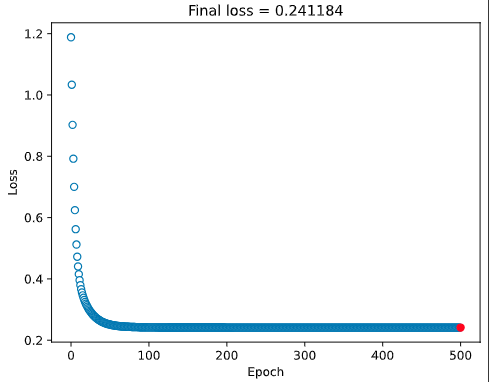

In [ ]:
# plot the data
plt.plot(x,y,'bo',label='Real data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f'prediction-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}')
plt.legend()
plt.show()
# If you ended up with a horizontal line, try to increase # of epochs

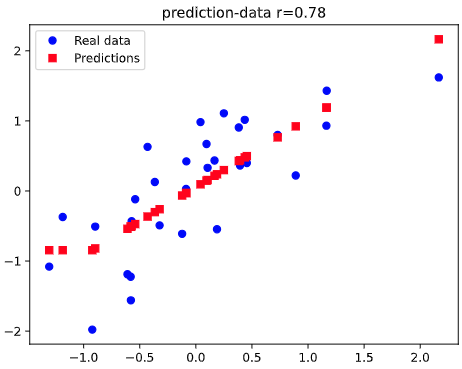

## ANN for Classification

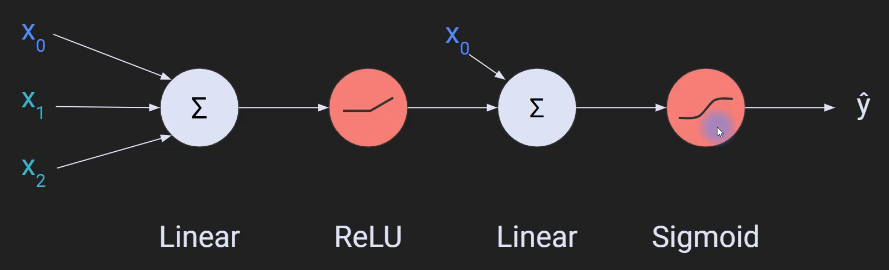